Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Data download setup

Install kaggle

In [ ]:
! pip install -q kaggle

Upload kaggle updated API for data download

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lexk00","key":"5a213a783108c14d74aee8317d84d93a"}'}

Make a directory to store kaggle API kaggle.json.  
Change kaggle.json permission to private read and write only

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Download kaggle dataset

In [ ]:
! kaggle competitions download -c tlvmc-parkinsons-freezing-gait-prediction

100% 58.5G/58.5G [10:53<00:00, 136MB/s]
100% 58.5G/58.5G [10:53<00:00, 96.1MB/s]


Unzip and extract train/defog and test/defog

In [ ]:
! mkdir data
! unzip /content/tlvmc-parkinsons-freezing-gait-prediction.zip -d /content/data

Archive:  /content/tlvmc-parkinsons-freezing-gait-prediction.zip
  inflating: /content/data/daily_metadata.csv  
  inflating: /content/data/defog_metadata.csv  
  inflating: /content/data/events.csv  
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/subjects.csv  
  inflating: /content/data/tasks.csv  
  inflating: /content/data/tdcsfog_metadata.csv  
  inflating: /content/data/test/defog/02ab235146.csv  
  inflating: /content/data/test/tdcsfog/003f117e14.csv  
  inflating: /content/data/train/defog/02ea782681.csv  
  inflating: /content/data/train/defog/06414383cf.csv  
  inflating: /content/data/train/defog/092b4c1819.csv  
  inflating: /content/data/train/defog/0c55be4384.csv  
  inflating: /content/data/train/defog/0d7ab3a9f9.csv  
  inflating: /content/data/train/defog/0eaac04f17.csv  
  inflating: /content/data/train/defog/0ec76d2d8e.csv  
  inflating: /content/data/train/defog/139f60d29b.csv  
  inflating: /content/data/train/defog/13a4fe5159.csv  
 

# Check and visualize training data: train/defog

## General training set check:
- Number of training files: 91 files.
- If all train files have the same column names: yes.
- If missing data exist: No.
- If exists significant amount of outliers:
- How are the features distributed
  - If normally distributed for numerical features: [to be checked].
  - If imbalanced for categorical features: yes.

In [ ]:
def data_paths(data = 'train'):
  path = '/content/data/'+data+'/defog'
  files = [os.path.join(path, f) for f in os.listdir(path)]
  return files

In [ ]:
def check_column_names(df):
  cols = df.columns.values.tolist()
  return len(cols), cols

In [ ]:
def general_data_check(data='train'):
    files = data_paths(data)
    print(f'Number of files in {data}/defog folder: {len(files)}')

    summary = [(check_column_names(pd.read_csv(file)), pd.read_csv(file).isnull().sum().tolist(), pd.read_csv(file).duplicated().sum())
               for file in files]

    if len(set([n_cols for n_cols, _ in summary])) == 1 and all(cols == summary[0][0][1] for _, cols, _ in summary):
        print(f'All files have {summary[0][0][0]} columns:')
        print(summary[0][0][1])

        if all(not any(missing) for missing in [missing_list for _, missing_list, _ in summary]):
            print(f'No missing data across {len(files)} {data} files.')
        else:
            print('Missing data exist.')

        if all(dups == 0 for _, _, dups in summary):
            print(f'No duplicated record across {len(files)} {data} files.')
        else:
            print('Duplicated record exist.')
    else:
        print('Number of columns differ or column names differ.')

    return [n_rows for _, _, n_rows in summary]


In [ ]:
n_rows = general_data_check(data = 'train')

Number of files in train/defog folder: 91
All files have 9 columns:
['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking', 'Valid', 'Task']
No missing data across 91 train files.
No duplicated record across 91 train files.


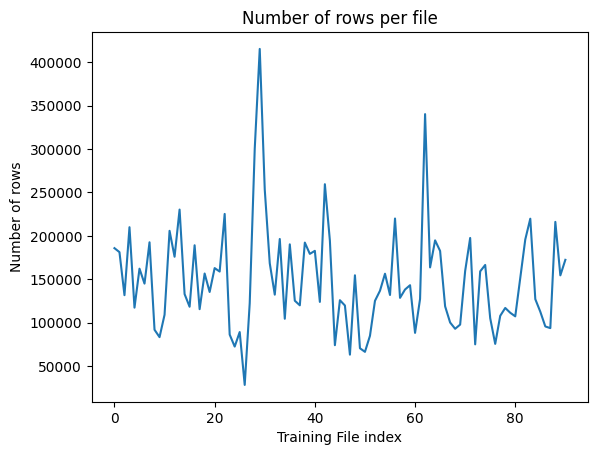

In [ ]:
plt.plot(n_rows)
plt.title('Number of rows per file')
plt.xlabel('Training File index')
plt.ylabel('Number of rows')
plt.show()

## Exploring Training data



In [ ]:
def event_types():
    files = data_paths(data='train')
    fs = ['StartHesitation', 'Turn', 'Walking']
    prev_type_comb = set()

    for i, file in enumerate(files):
        df = pd.read_csv(file)
        type_comb = set(df.groupby(fs).count()['Time'].index.values.tolist())
        prev_type_comb.update(type_comb)

    return list(prev_type_comb)

In [ ]:
def event_types_counts():
    type_comb = event_types()
    files = data_paths()
    fs = ['StartHesitation', 'Turn', 'Walking']
    all_types = []

    for file in files:
        df = pd.read_csv(file)
        types = df.groupby(fs).count()['Time'].index.values.tolist()
        values = df.groupby(fs).count()['Time'].values.tolist()
        nan_list = list(set(type_comb).difference(types))
        notnan_idx_list = [i for i, x in enumerate(type_comb) if x not in nan_list]
        new_types = [np.nan] * len(type_comb)
        new_types[:len(values)] = values
        all_types.append(new_types)

    return pd.DataFrame(all_types, columns=[''.join(map(str, tup)) for tup in type_comb])


In [ ]:
event_types_counts_df = event_types_counts()

In [ ]:
new_event_types_counts_df = event_types_counts_df.copy(deep = True)
new_event_types_counts_df.columns = ['Normal', 'Walking', 'Turn', 'StartHesitation']
print('Number of files containing the corresponding FoG event type: ')
[91]*4 - new_event_types_counts_df.isna().sum()

Number of files containing the corresponding FoG event type: 


Normal             91
Walking            55
Turn               90
StartHesitation     7
dtype: int64

Text(0.5, 0, 'Total Timesteps During Which the Specified Type Occured')

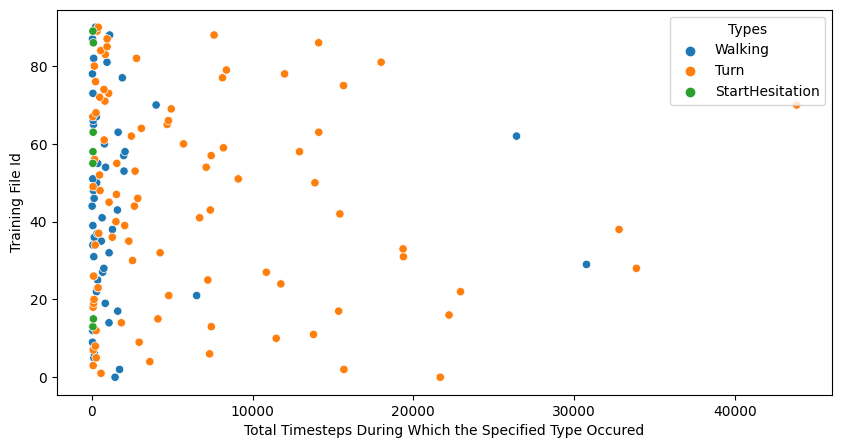

In [ ]:
new_event_types_counts_df = event_types_counts_df.copy(deep = True)
new_event_types_counts_df['id'] = new_event_types_counts_df.index.values
new_event_types_counts_df.columns.values[:-1] = ['Normal', 'Walking', 'Turn', 'StartHesitation'] #'id' is the last column
# Convert df from wide to long for plotting
melted_event_types_counts_df = new_event_types_counts_df.melt(id_vars='id', var_name='Types', value_name='Counts')



plt.figure(figsize=(10, 5))
sns.scatterplot(x='Counts', y='id', hue='Types', data=melted_event_types_counts_df[melted_event_types_counts_df.Types != 'Normal'])
plt.ylabel('Training File Id')
plt.xlabel('Total Timesteps During Which the Specified Type Occurred')

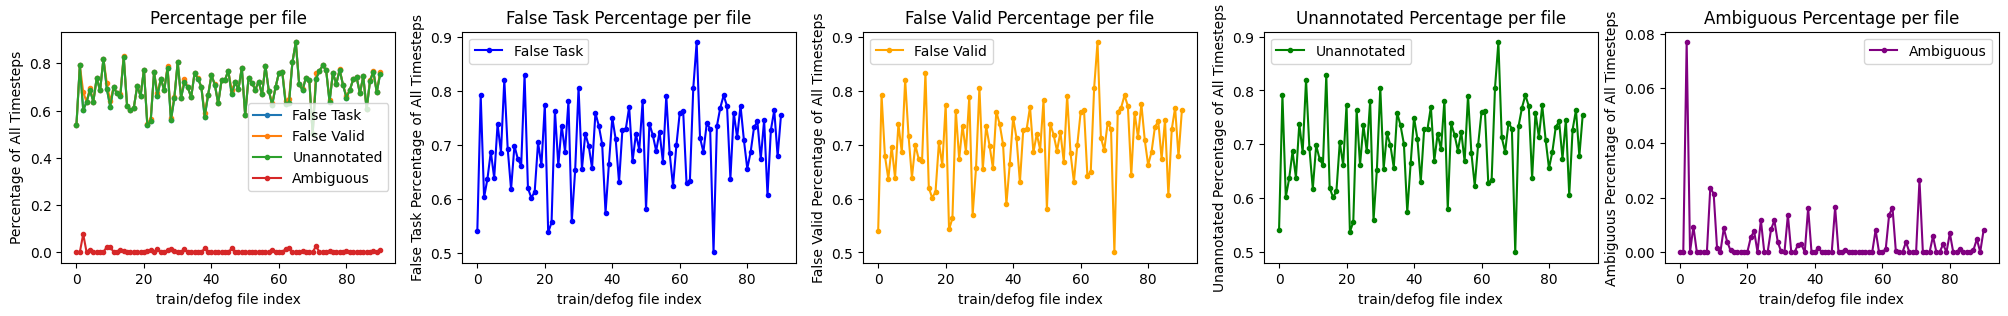

In [ ]:
task_neg_rates, valid_neg_rates, both_neg_rates, ambi_rates = [], [], [], []

for file in data_paths('train'):
    df = pd.read_csv(file)
    total_timesteps = df.shape[0]

    task_neg_rates.append(df.Task.value_counts()[0] / total_timesteps)
    valid_neg_rates.append(df.Valid.value_counts()[0] / total_timesteps)
    both_neg_rates.append(df[(df.Task == 0) & (df.Valid == 0)].shape[0] / total_timesteps)
    ambi_rates.append(df[(df.Task == 1) & (df.Valid == 0)].shape[0] / total_timesteps)

fig, axes = plt.subplots(1, 5, figsize=(25, 3))

rates = [task_neg_rates, valid_neg_rates, both_neg_rates, ambi_rates]
labels = ['False Task', 'False Valid', 'Unannotated', 'Ambiguous']
colors = ['blue', 'orange', 'green', 'purple']

for rate, label, color, ax in zip(rates, labels, colors, axes.flatten()):
    ax.plot(rate, marker='.', label=label, c=color) if label != 'Ambiguous' else ax.plot(
        task_neg_rates, marker='.', label='False Task'
    ), ax.plot(valid_neg_rates, marker='.', label='False Valid'), ax.plot(
        both_neg_rates, marker='.', label='Unannotated'
    ), ax.plot(ambi_rates, marker='.', label='Ambiguous')
    ax.legend()
    ax.set_xlabel('train/defog file index')
    ax.set_ylabel(f'{label} Percentage of All Timesteps')
    ax.set_title(f'{label} Percentage per file')

axes[0].legend()
axes[0].set_xlabel('train/defog file index')
axes[0].set_ylabel('Percentage of All Timesteps')
axes[0].set_title('Percentage per file')

plt.show()


In [ ]:
print(f"""Highest Ambiguous percentage: {max(ambi_rates)}
File: {files[np.array(ambi_rates).argmax()]}
""")

Highest Ambiguous percentage: 0.07682963862739144
File: /content/data/train/defog/c50f164e00.csv



### Check how ambiguous and unannotated records distribute per event type.


In [ ]:
def check_unannotated_n_ambiguous_types(df):
  # Reverse one hot encoding to a single categorical feature 'Types'
  df_new = df[[f for f in df.columns.values.tolist() if f not in ['StartHesitation', 'Turn', 'Walking']]].copy()
  df_new['Types'] = df.apply(rev_ohe_types, axis = 1)
  ambiguous = (df_new.Task == True) & (df_new.Valid == False)
  unannotated = (df_new.Task == False) & (df_new.Valid == False)

  ambi_d = df_new[ambiguous]['Types'].value_counts().to_dict()
  unanno_d = df_new[unannotated]['Types'].value_counts().to_dict()

  return ambi_d, unanno_d

In [ ]:
def check_all_unannotated_n_ambiguous_types():
  files = data_paths(data = 'train')
  ambi_sum_d = {k:[] for k in ['Normal', 'StartHesitation', 'Turn', 'Walking']}
  unanno_sum_d = {k:[] for k in ['Normal', 'StartHesitation', 'Turn', 'Walking']}
  for i, file in enumerate(files):
    df = pd.read_csv(file)
    ambi_d, unanno_d = check_unannotated_n_ambiguous_types(df)
    if i % 10 == 0 or i == len(files) - 1:
      print(f'File No.{i}: Loaded')

    # Check how are ambiguous event types distributed
    for k, v in ambi_sum_d.items():
      if k in ambi_d.keys():
        v.append(ambi_d[k])
      else:
        v.append(0)

    # Check if all files' unannotated event types are 'Normal'
    for k, v in unanno_sum_d.items():
      if k in unanno_d.keys():
        v.append(unanno_d[k])
      else:
        v.append(0)
  return ambi_sum_d, unanno_sum_d


In [ ]:
ambi_sum_d, unanno_sum_d = check_all_unannotated_n_ambiguous_types()

File No.0: Loaded
File No.10: Loaded
File No.20: Loaded
File No.30: Loaded
File No.40: Loaded
File No.50: Loaded
File No.60: Loaded
File No.70: Loaded
File No.80: Loaded
File No.90: Loaded


In [ ]:
print(f"""Highest number of ambiguous records:
  File: {files[np.array(ambi_sum_d['Normal']).argmax()]}
  Ambiguous record count: {ambi_sum_d['Normal'][np.array(ambi_sum_d['Normal']).argmax()]}
""")

Highest number of ambiguous records:
  File: /content/data/train/defog/c50f164e00.csv
  Ambiguous record count: 10117




Of all ambiguous events across all files:

Number of files with ambiguous StartHesitation events: 0
Number of files with ambiguous Turn events: 10
Number of files with ambiguous Walking events: 1
Number of files with ambiguous Normal events: 90



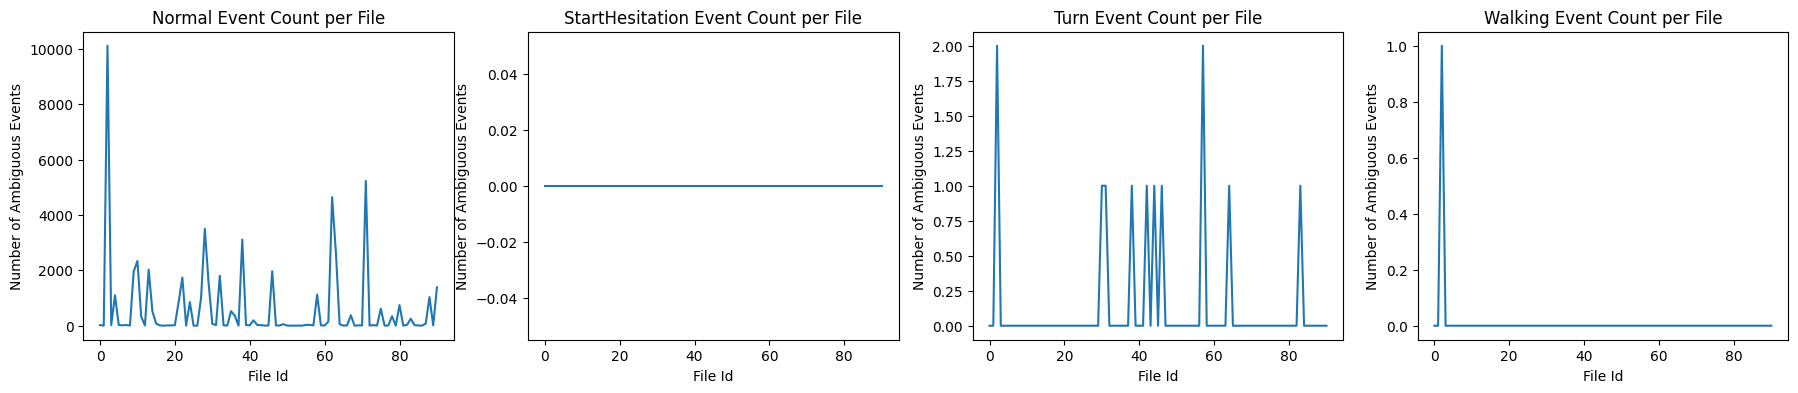

In [ ]:
ambi_df = pd.DataFrame(ambi_sum_d)
ambi_df.describe()
print(f"""
Of all ambiguous events across all files:

Number of files with ambiguous StartHesitation events: {ambi_df.loc[ambi_df["StartHesitation"] != 0, :].shape[0]}
Number of files with ambiguous Turn events: {ambi_df.loc[ambi_df["Turn"] != 0, :].shape[0]}
Number of files with ambiguous Walking events: {ambi_df.loc[ambi_df["Walking"] != 0, :].shape[0]}
Number of files with ambiguous Normal events: {ambi_df.loc[ambi_df["Normal"] != 0, :].shape[0]}
""")
fig, axes = plt.subplots(1,4,figsize = (22,4))
for col, ax in zip(ambi_df.columns.tolist(), axes.flatten()):
  ax.plot(ambi_df[col])
  ax.set_xlabel('File Id')
  ax.set_ylabel(f'Number of Ambiguous Events')
  ax.set_title(f'{col} Event Count per File')
plt.show()


Of all unannotated events across all files:

Number of files with unannotated StartHesitation events: 0
Number of files with unannotated Turn events: 1
Number of files with unannotated Walking events: 0
Number of files with unannotated Normal events: 91


File name with unannotated Turn event: daa4d27db4.csv



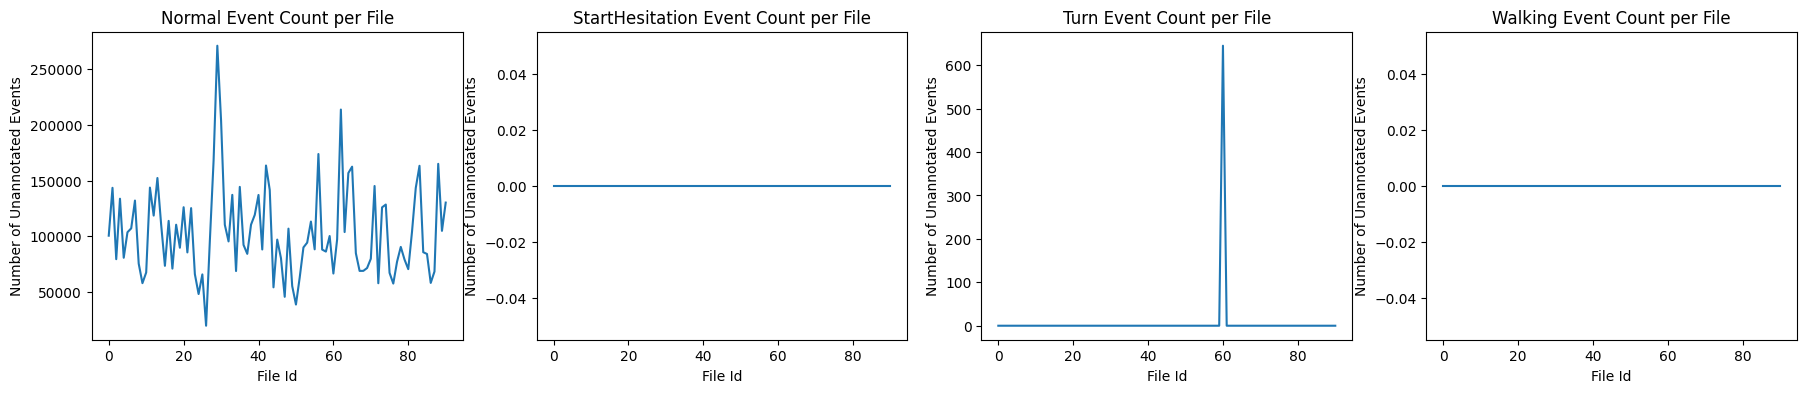

In [ ]:
unanno_df = pd.DataFrame(unanno_sum_d)
unanno_df.describe()

print(f"""
Of all unannotated events across all files:

Number of files with unannotated StartHesitation events: {unanno_df.loc[unanno_df["StartHesitation"] != 0, :].shape[0]}
Number of files with unannotated Turn events: {unanno_df.loc[unanno_df["Turn"] != 0, :].shape[0]}
Number of files with unannotated Walking events: {unanno_df.loc[unanno_df["Walking"] != 0, :].shape[0]}
Number of files with unannotated Normal events: {unanno_df.loc[unanno_df["Normal"] != 0, :].shape[0]}
""")

print(f"""
File name with unannotated Turn event: {files[unanno_df.loc[unanno_df["Turn"] != 0, :].index.values[0]].split('/')[-1]}
""")

fig, axes = plt.subplots(1,4,figsize = (22,4))
for col, ax in zip(unanno_df.columns.tolist(), axes.flatten()):
  ax.plot(unanno_df[col])
  ax.set_xlabel('File Id')
  ax.set_ylabel(f'Number of Unannotated Events')
  ax.set_title(f'{col} Event Count per File')
plt.show()

### Check time series of AccV, AccML, and AccAP

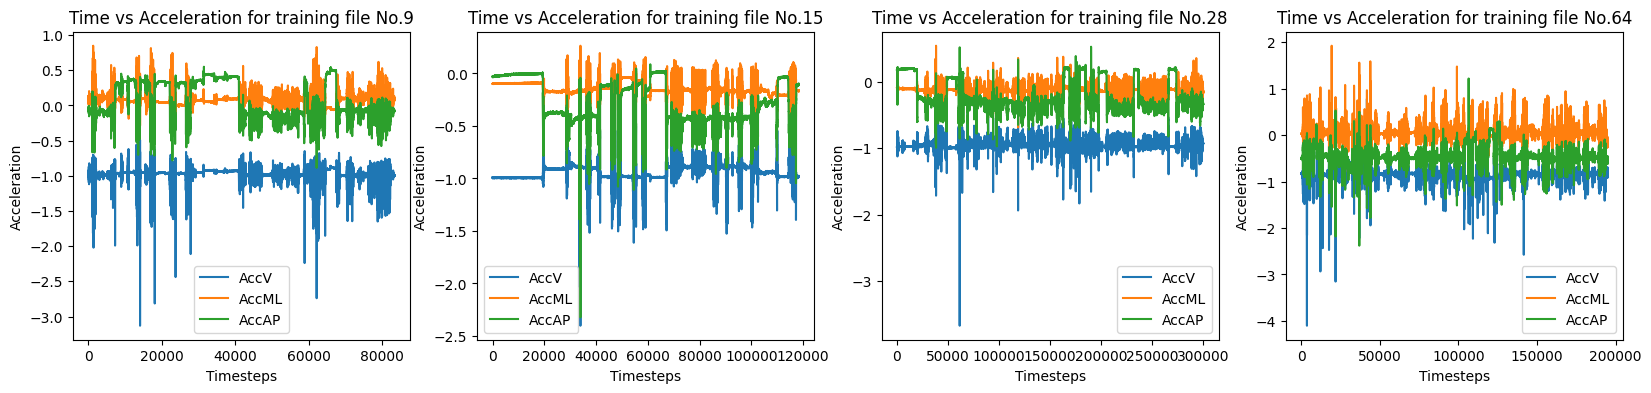

In [ ]:
import numpy.random as random

random.seed(10)
file_idx = random.randint(91, size=4)
file_idx.sort()
random_files = [files[i] for i in file_idx]

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for ax, file_idx, file in zip(axes.flatten(), file_idx, random_files):
    df = pd.read_csv(file)
    for acc_type in ['AccV', 'AccML', 'AccAP']:
        sns.lineplot(x='Time', y=acc_type, data=df, label=acc_type, ax=ax)
    ax.legend()
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Acceleration')
    ax.set_title(f'Time vs Acceleration for training file No.{file_idx}')


### Check correlation of all features.

In [ ]:
def plot_random_corr_heatmap(nPlots=4, seed=10):
    random.seed(seed)
    file_idx = random.randint(91, size=nPlots)
    file_idx.sort()
    random_files = [files[i] for i in file_idx]

    fig, axes = plt.subplots(1, nPlots, figsize=(nPlots * 8, 6))

    for file_idx, file, ax in zip(file_idx, random_files, axes.flatten()):
        df = pd.read_csv(file)
        df['Types'] = df.apply(rev_ohe_types, axis=1)
        features = ['AccV', 'AccML', 'AccAP'] + [f for f in df['Types'].value_counts().index.tolist() if f != 'Normal']
        sns.heatmap(df[features].corr(), ax=ax)
        ax.set_title(f'Correlation Heatmap for file No.{file_idx}')

    plt.show()


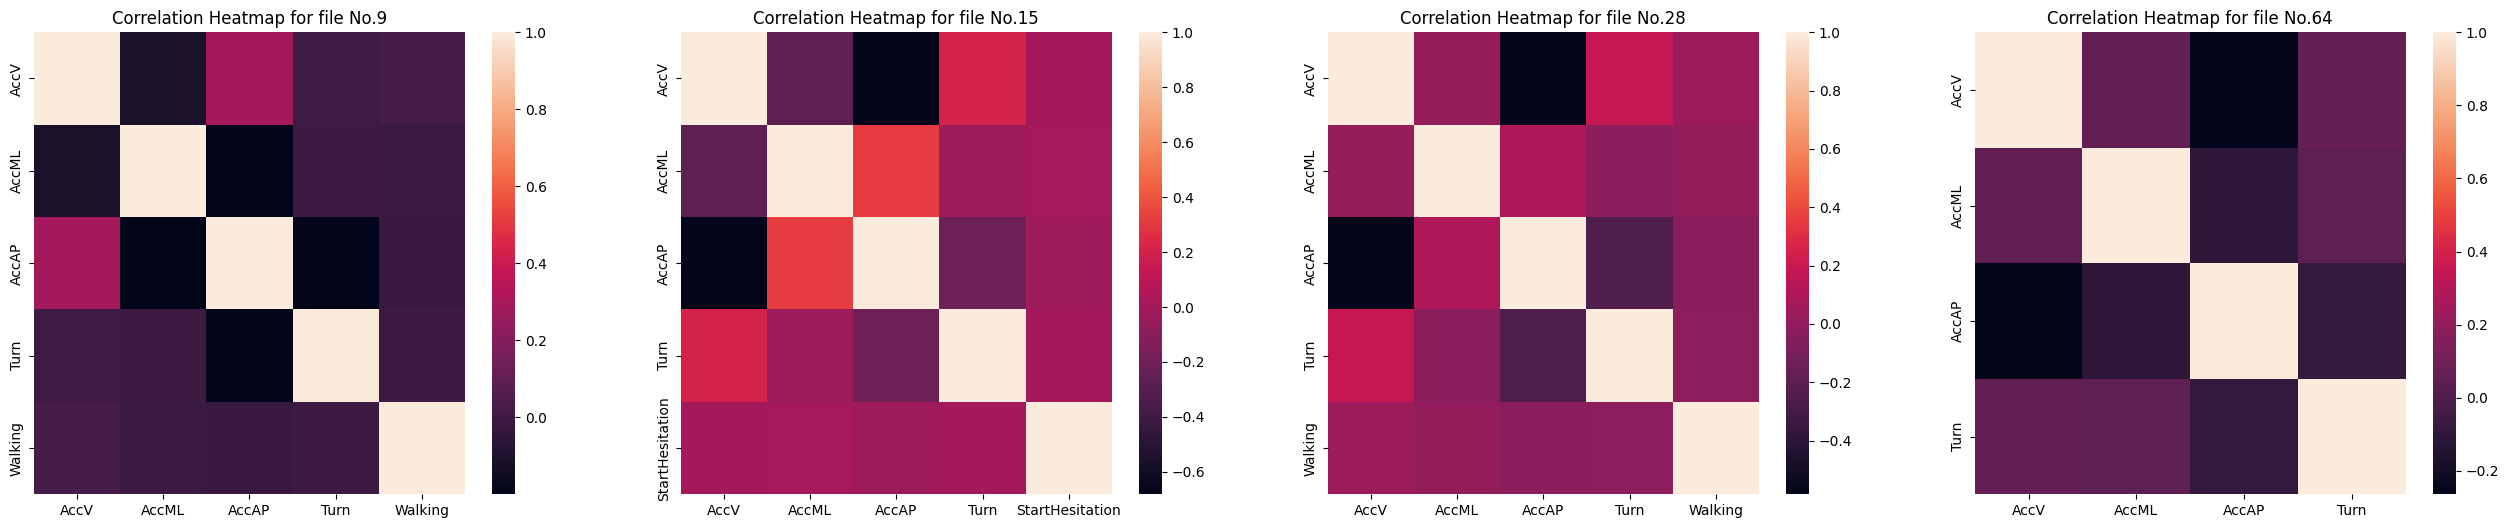

In [ ]:
plot_random_corr_heatmap(nPlots = 4, seed = 10)

### Check how time series acceleration varies with different types.  


In [ ]:
def rev_ohe_types(row):
  f = ['StartHesitation', 'Turn', 'Walking']
  if row['StartHesitation'] == 0 and row['Turn'] == 0 and row['Walking'] == 0:
    return 'Normal'
  if row['StartHesitation'] == 0 and row['Turn'] == 1 and row['Walking'] == 0:
    return 'Turn'
  if row['StartHesitation'] == 0 and row['Turn'] == 0 and row['Walking'] == 1:
    return 'Walking'
  if row['StartHesitation'] == 1 and row['Turn'] == 0 and row['Walking'] == 0:
    return 'StartHesitation'

In [ ]:
def plot_random_acceleration_types(acc_type, nPlots=4, seed=10):
    random.seed(seed)
    file_idx = random.randint(91, size=nPlots)
    file_idx.sort()
    random_files = [files[i] for i in file_idx]

    fig, axes = plt.subplots(nPlots, 1, figsize=(20, 6 * nPlots))

    for file_idx, file, ax in zip(file_idx, random_files, axes.flatten()):
        df = pd.read_csv(file)
        df['Types'] = df.apply(rev_ohe_types, axis=1)
        sns.lineplot(x='Time', y=acc_type, hue='Types', data=df, ax=ax)
        ax.set_xlabel('Timesteps')
        ax.set_ylabel(acc_type)
        ax.set_title(f'{acc_type} series for file No.{file_idx}')

    plt.show()


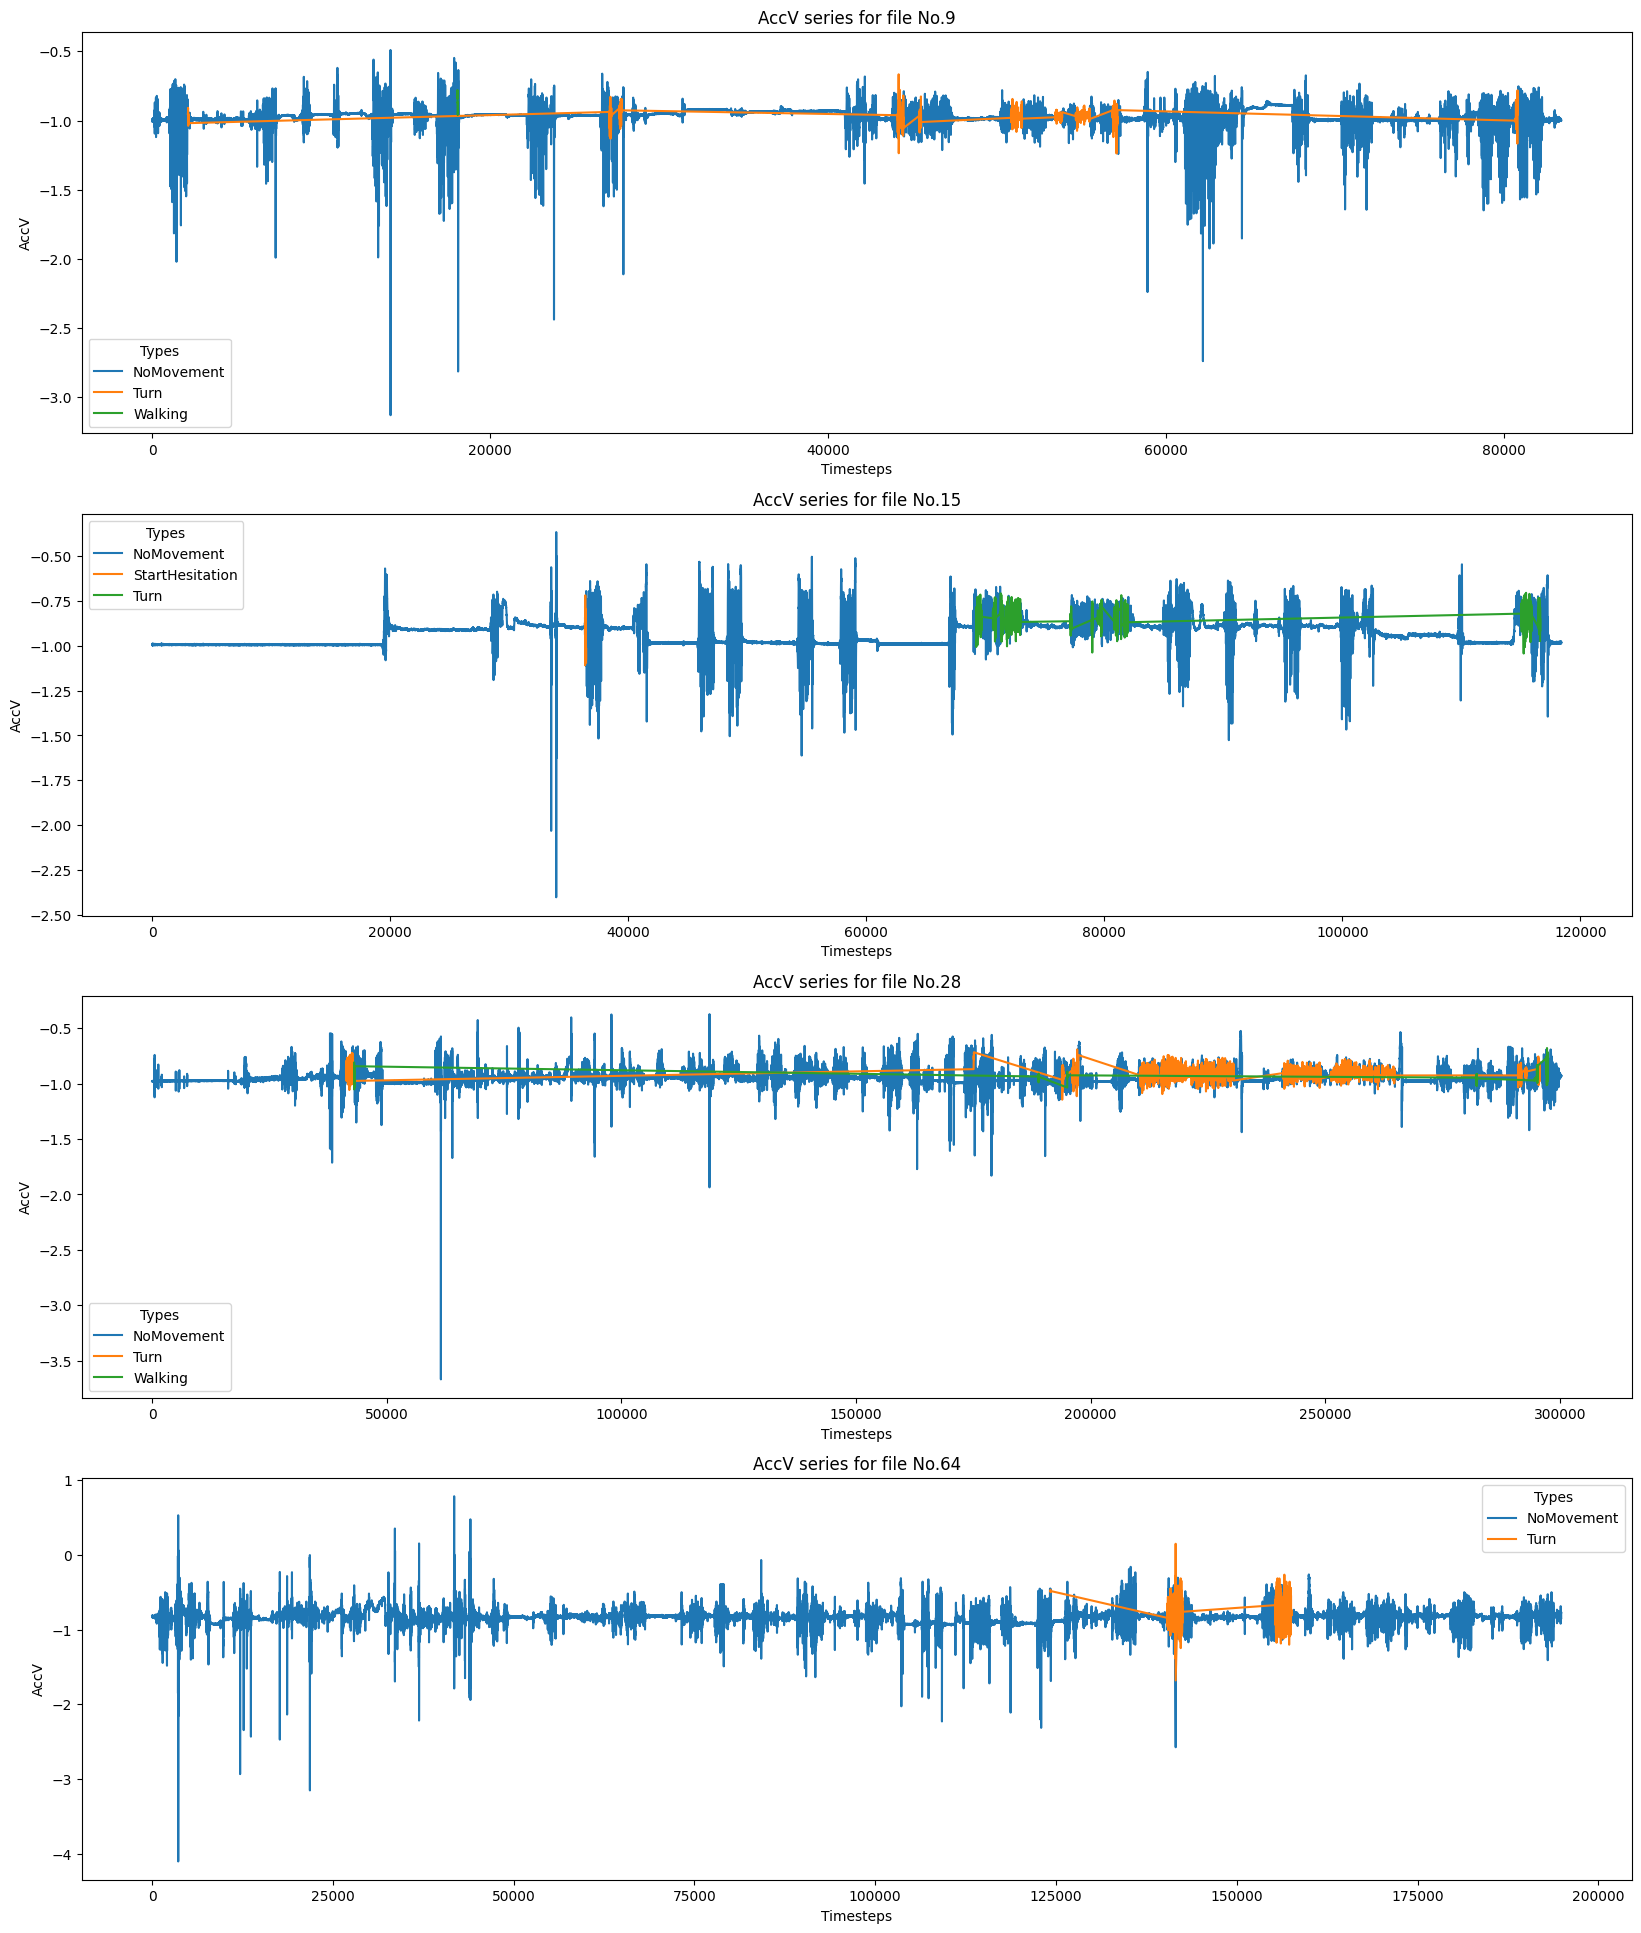

In [ ]:
plot_random_acceleration_types('AccV', nPlots = 4, seed = 10)

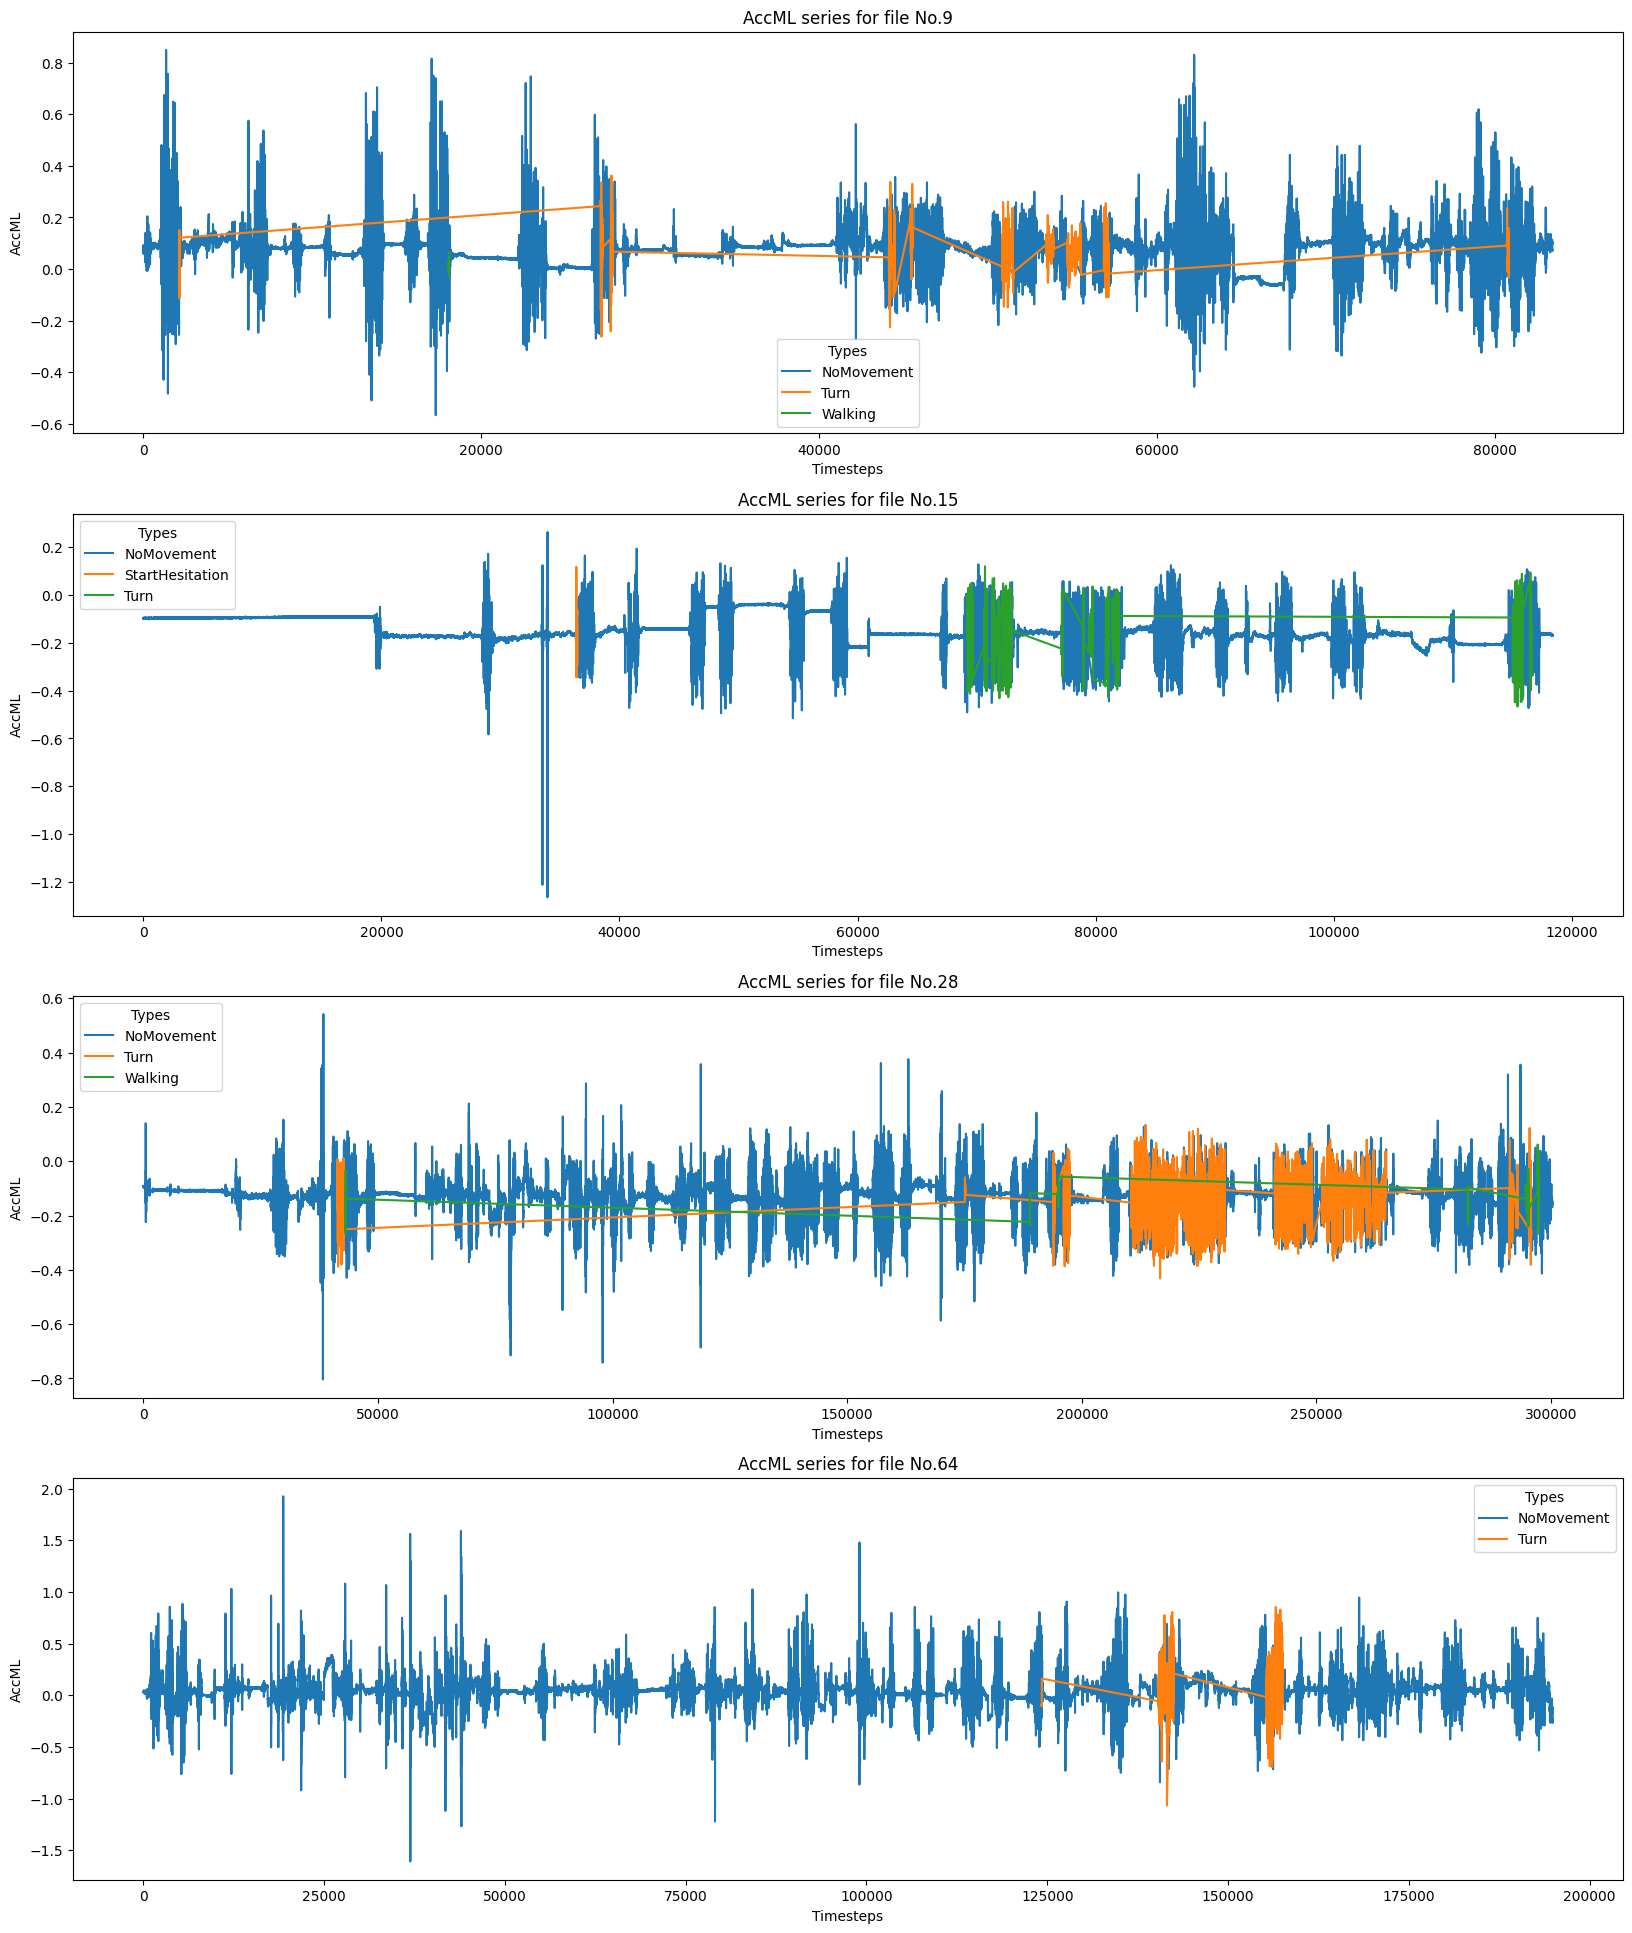

In [ ]:
plot_random_acceleration_types('AccML', nPlots = 4, seed = 10)

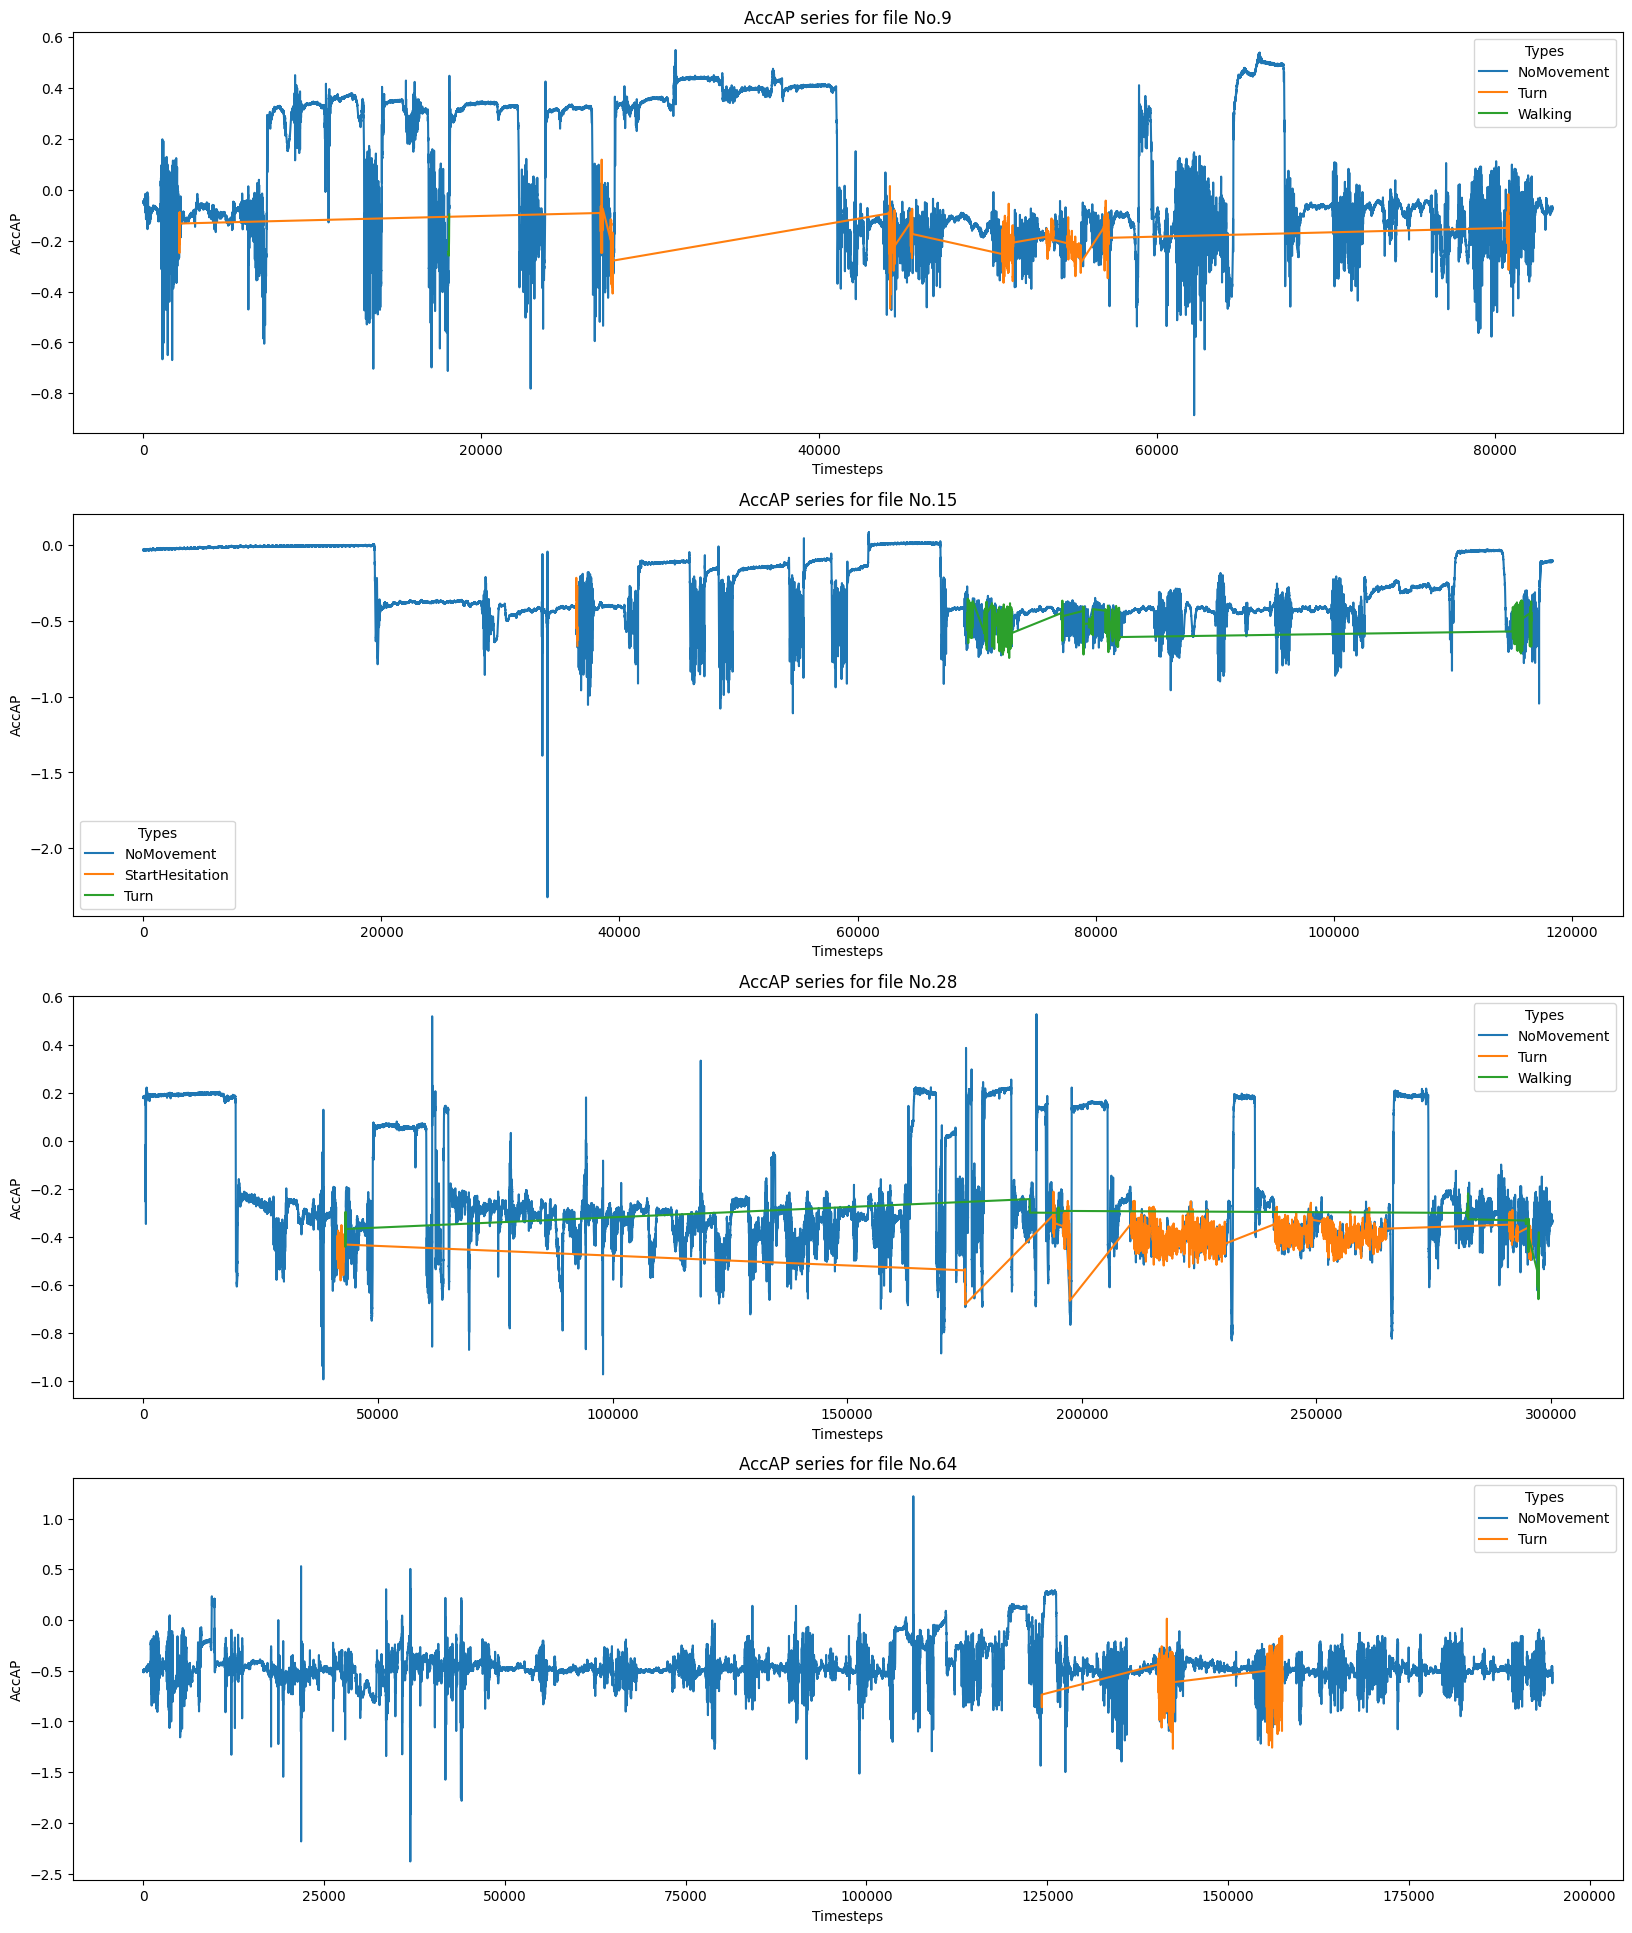

In [ ]:
plot_random_acceleration_types('AccAP', nPlots = 4, seed = 10)